# Brooklyn Food Waste Data Analysis

This project analyzes the data of various products that were found in the randomly selected trash piles from Downtown Brooklyn neighborhood in New York City.
This project specifically focuses on the various factors related to food being disposed before their expiration date. Mainly, this project will focus on the following variables:
- Label Language
- Retailer Type & Food Type
- Organic Food Type

In [123]:
# import necessary libaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df = pd.read_csv("brooklyn.csv")

In [60]:
df.head()

,id,date_collected,retailer_type,retailer_detail,food_type,food_detail,label_type,label_language,label_date,approximate_dollar_value,image_id,collection_lat,collection_long,label_explanation
0,5e31d5503b85a2e63d634187,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic oatmeal,sticker,use by,2020-01-28,5.25,IMG_1872,40.69453,-73.99447,NaN
1,5e31d5643b85a2e63d634188,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic oatmeal,sticker,use by,2020-01-28,5.25,IMG_1873,40.69453,-73.99447,NaN
2,5e31d8903b85a2e63d634189,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic middle eastern salad,sticker,use by,2020-01-28,10.00,IMG_1874,40.69453,-73.99447,NaN
3,5e31dcee3b85a2e63d63418a,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic oatmeal,sticker,use by,2020-01-28,6.25,IMG_1875,40.69453,-73.99447,NaN
4,5e31dd273b85a2e63d63418b,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic mexican salad,sticker,use by,2020-01-28,10.00,IMG_1876,40.69453,-73.99447,NaN


#### First, calculating the difference between the date the trash was collected and the date it was supposed to be sold before/ expired, etc. 
This gives us a rough estimate of the ***number of days*** before the label date that the food was thrown out, assuming that the food was disposed somewhere near the collection date

- A positive value means that the food was trashed <span style="color: red;">before</span> the mentioned date on the label
- A negative value means that it was thrown <span style="color: green;">after</span> or somewhere near the mentioned date

In [61]:
# converting the required columns to datetime type first

df['date_collected'] = pd.to_datetime(df['date_collected'], errors='coerce')

In [62]:
df['label_date'] = pd.to_datetime(df['label_date'], errors='coerce')

In [63]:
df = df[df['label_date'].notna()]

In [64]:
df['diff'] = df['label_date']-df['date_collected']

In [65]:
# removing outliers

df = df[(df['diff'] > df['diff'].quantile(.05)) & (df['diff'] < df['diff'].quantile(0.95))]

In [66]:
# a workaround for converting the datetime difference to int: [there seemed to be an erroneous entry]

df['diff'] = df['diff'].astype('str').apply(lambda x: x.split(' ')[0]).astype('int')

## Label Language
Calculating the number of the kinds of labels found, and calculating the average number of days before the food with that particular label on it was thrown out

In [67]:
df_labels = df.groupby('label_language').agg({'id':'count', 'diff':'mean'})
df_labels.columns = ['count','diff']

#### Taking the five labels that were encountered the most when collecting the waste

In [68]:
df_labels.nlargest(5, 'count')

,count,diff
label_language,,
sell by,31,0.903226
sell thru,25,-0.520000
exp,14,-1.428571
use by,14,0.214286
best if used by,5,-0.200000


<AxesSubplot:xlabel='label_language'>

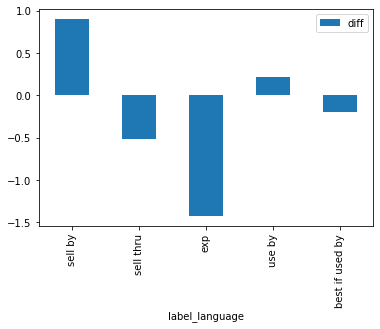

In [69]:
df_labels.nlargest(5, 'count').plot.bar(y='diff')

Through the data, it seems that words on the label like 'sell by', 'use by' lead to the product being thrown out quicker, and other words like 'best if used by' seems to lead the product being thrown out later(after or near) the mentioned date.
**I believe, however, that this conjecture can be made more reliable with more data.**

## Retailer Type & Food Type

#### Calculating the average difference in the days for each retailer type

<AxesSubplot:xlabel='retailer_type'>

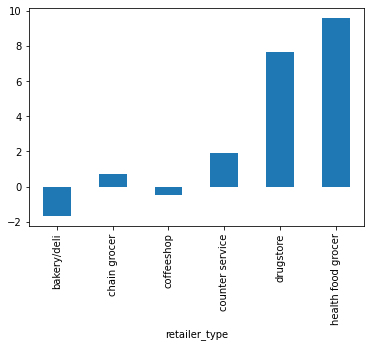

In [70]:
df.groupby('retailer_type')['diff'].mean().plot(kind='bar')

Items from the ***health food grocer*** and ***drugstore*** seem to be thrown out way before they are supposed to

We have a lot more waste from the drugstore, chain grocer, bakery, and the health food grocer in general

In [71]:
df.groupby('retailer_type').count().id.to_frame().sort_values(by='id', ascending=False)

,id
retailer_type,
drugstore,39
chain grocer,34
bakery/deli,31
health food grocer,30
counter service,9
coffeeshop,2


From the items being thrown out early from these stores, most of them are perishable as seen in the data below. Perishable food can be hazardous after a certain time, so it is understandable why people would want to throw them out. However, determining the time by looking at the label date isn't always the best idea because ["they aren’t usually about food safety."](https://health.clevelandclinic.org/trash-it-or-eat-it-the-truth-about-expiration-dates/)

In [72]:
df[df['retailer_type']=='health food grocer']['food_type'].value_counts()

perishable    30
Name: food_type, dtype: int64

In [73]:
df[df['retailer_type']=='drugstore']['food_type'].value_counts()

perishable      23
ready-to-eat    10
packaged         6
Name: food_type, dtype: int64

#### This graph shows a trend of perishable food being thrown out earlier than other kinds of food in general

<AxesSubplot:xlabel='food_type'>

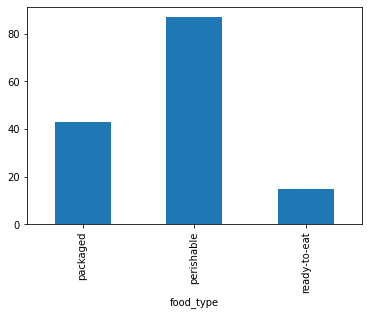

In [74]:
df.groupby('food_type')['id'].count().plot(kind='bar')

#### Certain food items are disposed more in the area and before they are supposed to be thrown out

In [75]:
df_food = df.groupby('food_detail').agg({'id':'count', 'diff':'mean'}).sort_values(by='id', ascending=False).head(10).reset_index()

In [76]:
df_food.columns = ['food_detail','count','diff']

In [77]:
df_food

,food_detail,count,diff
0,yogurt,17,1.882353
1,flatbread pepperoni pizza,7,0.000000
2,honey turkey and swiss wrap,7,-2.714286
3,pasteurized grade a goat milk,5,3.000000
4,mixed fruit cup,5,-0.200000
5,red velvet cake slice,4,3.500000
6,organic riced cauliflower,4,-1.000000
7,organic energy bar,4,3.000000
8,california roll sushi,4,-1.000000
9,chocolate cake,3,1.000000


#### Dairy and bakery items like yogurt, goat milk, and cakes seem to be trashed early

<AxesSubplot:xlabel='food_detail'>

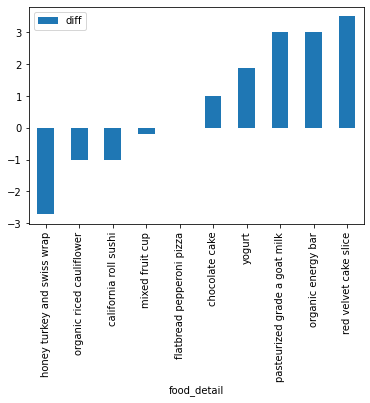

In [78]:
df_food.sort_values(by='diff').plot.bar(x='food_detail',y='diff')

Let's see if the same kind of items are sold in different stores, and if they have different properties

In [79]:
df_r = df.groupby(['retailer_type', 'food_detail'])['diff'].mean().to_frame().reset_index()
#

In [80]:
# Getting items that are sold in different retailers

dup = df_r[df_r['food_detail'].duplicated()]

Getting all the duplicate values and arranging them

In [81]:
df_duplicates = df[df['food_detail'].apply(lambda x: x in dup['food_detail'].to_list())]

In [82]:
df_duplicates = df_duplicates.groupby(['retailer_type', 'food_detail']).agg({'diff':'mean','id':'count'})
df_duplicates.columns = ['diff','count']
df_duplicates.head()

,,diff,count
retailer_type,food_detail,,
bakery/deli,cut cantaloupe,-2.000000,1
chain grocer,cut cantaloupe,0.000000,2
drugstore,yogurt,2.133333,15
health food grocer,yogurt,0.000000,2


From the data above, it shows that the drugstore yogurt was found in significantly higher amount in the trash piles.
Moreover, the drugstore yogurt seems to be thrown out earlier than the yogurt from the health food grocer.

## Organic Food Type

In [83]:
df['organic'] = df['food_detail'].apply(lambda x: ('organic' in x)*1)

A lot of the food items that were thrown out seemed to have the word **organic**: 121 to be precise

In [84]:
df.groupby('organic')['diff'].sum()

organic
0    454
1    121
Name: diff, dtype: int32

In general, organic food items seem to be thrown out **earlier** than other food items

In [85]:
df.groupby('organic')['diff'].mean()

organic
0    3.752066
1    5.041667
Name: diff, dtype: float64

## Linear Regression Model

Let's make a machine learning model to predict how many days before or after the expiration date, a product would be thrown out.

In [102]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Removing all the columns that we won't use as features:

In [242]:
df_encoded = df.copy()
df_encoded.drop(['id', 'date_collected', 'label_date', 'image_id', 'label_explanation','label_type','collection_lat','collection_long','food_detail'], inplace=True, axis=1)
df_encoded.head()

,retailer_type,retailer_detail,food_type,label_language,approximate_dollar_value,diff,organic
0,counter service,ready-to-eat and prepackaged health food,ready-to-eat,use by,5.25,1,1
1,counter service,ready-to-eat and prepackaged health food,ready-to-eat,use by,5.25,1,1
2,counter service,ready-to-eat and prepackaged health food,ready-to-eat,use by,10.00,1,1
3,counter service,ready-to-eat and prepackaged health food,ready-to-eat,use by,6.25,1,1
4,counter service,ready-to-eat and prepackaged health food,ready-to-eat,use by,10.00,1,1


We decide to use **One Hot Encoding** to encode our values for the model because it seems to give far more accurate predictions than manual label encoding in our case.

In [243]:
df_encoded = pd.get_dummies(df_encoded, columns=["label_language","retailer_type","retailer_detail","food_type"])
df_encoded.head()

,approximate_dollar_value,diff,organic,label_language_12619,label_language_bb,label_language_best by,label_language_best if used by,label_language_enjoy by,label_language_exp,label_language_expires,...,retailer_type_drugstore,retailer_type_health food grocer,retailer_detail_ready-to-eat and prepackaged food,retailer_detail_ready-to-eat and prepackaged health food,"retailer_detail_ready-to-eat, shelf-stable, and frozen food","retailer_detail_ready-to-eat, shelf-stable, frozen, and perishable food","retailer_detail_ready-to-eat, shelf-stable, frozen, and perishable health food",food_type_packaged,food_type_perishable,food_type_ready-to-eat
0,5.25,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,5.25,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,10.00,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,6.25,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,10.00,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


Manual Label Encoding:

In [244]:
# for col in ['retailer_type', 'retailer_detail', 'food_type', 'label_language']:
#     df_encoded[col] = df[col].astype('category').cat.codes

# df_encoded.head()

**Training and Testing Data**

In [245]:
y = df_encoded['diff']
X = df_encoded.drop('diff', axis=1)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [247]:
lm = LinearRegression()

In [249]:
lm.fit(X_train,y_train)

LinearRegression()

In [250]:
predictions = lm.predict( X_test)

**Predicting Test Data**

Text(0, 0.5, 'Predicted Y')

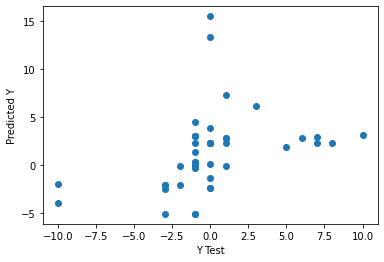

In [251]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

**Plotting a histogram of the residuals**

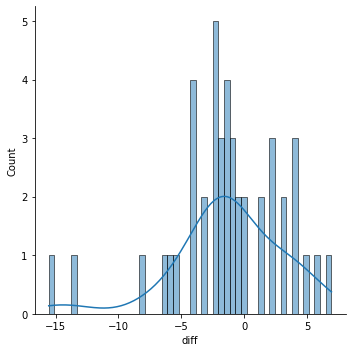

In [258]:
sns.displot((y_test-predictions),bins=50, kde=True)

**Evaluating our model**

In [254]:
# calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.381044811158415
MSE: 20.789783539584132
RMSE: 4.559581509259828


## Conclusion

The dataset provided some interesting insights into the food waste situation of a Downtown Brooklyn neighborhood. There seemed to be some interesting patterns like organic food being thrown out more often, when organic food are sometimes marketed as better for the environment. The claims made in this report and our machine learning model could be solidified with more data. Especially some conjectures like certain food items being more popular in some areas and the effect of the sentiment of label language on different food items can be made more trust-worthy in further research. 